In [529]:
from scipy.stats import ks_2samp, iqr
from scipy.stats import ttest_ind
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [530]:
# set paths
data_dir = "./"
# files extracted by prepare_evaluation_input.py script
sim_file = "simulator_output/orders_times.csv"
#sim_file = "simulator_output/orders_times_SEV_2019-12-01_2019-12-01.csv"
dwh_file = "reality_data/SEV_2019-12-01_2019-12-01.csv"


# read data
sim_dt = pd.read_csv(os.path.join(data_dir, sim_file))
real_dt = pd.read_csv(os.path.join(data_dir, dwh_file))



In [531]:
sim_dt.head()

,Unnamed: 0,Unnamed: 1,timestamp_hms,timestamp_hms.1,timestamp_hms.2,timestamp_hms.3,timestamp_hms.4,timestamp_hms.5,timestamp_hms.6,timestamp_hms.7,timestamp_hms.8,timestamp_hms.9,timestamp_hms.10,timestamp_hms.11,timestamp_hms.12,timestamp_seconds,timestamp_seconds.1,timestamp_seconds.2,timestamp_seconds.3,timestamp_seconds.4,timestamp_seconds.5,timestamp_seconds.6,timestamp_seconds.7,timestamp_seconds.8,timestamp_seconds.9,timestamp_seconds.10,timestamp_seconds.11,timestamp_seconds.12,times_diff,times_diff.1,times_diff.2,times_diff.3,times_diff.4,times_diff.5,times_diff.6,times_diff.7,times_diff.8,times_diff.9,times_diff.10,times_diff.11
0,event,NaN,courier_arrived_at_delivery,courier_at_pickup,courier_starts_order,first_stack_order_courier,food_ready,last_stacking,new_stack_order_courier,order_courier_dispatched,order_delivered,order_new,order_picked_up,partner_start_preparing_order,send_order_partner,courier_arrived_at_delivery,courier_at_pickup,courier_starts_order,first_stack_order_courier,food_ready,last_stacking,new_stack_order_courier,order_courier_dispatched,order_delivered,order_new,order_picked_up,partner_start_preparing_order,send_order_partner,courier_delivery_time,customer_delivery_time,activation_to_first_stacking,first_stacking_to_last_stacking,last_stacking_to_courier_start,start_to_pickup_time,waiting_time_pickup,food_getting_cold,pickup_to_delivery_time,waiting_delivery_time,activation_to_partner_dispatch,partner_dispatch_to_enter_pickup
1,NaN,order_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,81792709.0,NaN,09:36:53,09:15:00,09:04:00,09:56:53,09:04:00,NaN,09:15:00,NaN,09:00:15,09:56:53,09:36:53,09:16:53,NaN,34613.0,33300.0,32640,35813.0,32640,NaN,33300.0,NaN,32415,35813.0,34613.0,33413.0,NaN,NaN,225.0,0.0,660.0,1313.0,1200.0,0.0,NaN,NaN,998.0,1200.0
3,1,81844640.0,08:43:57,08:31:02,08:19:00,08:12:00,08:31:53,08:12:00,NaN,08:19:00,08:47:54,00:00:30,08:31:53,08:18:22,08:18:22,31437.0,30662.0,29940.0,29520,30713.0,29520,NaN,29940.0,31674.0,30,30713.0,29902.0,29902.0,1734.0,31644.0,29490.0,0.0,420.0,722.0,51.0,0.0,724.0,237.0,29872.0,760.0
4,2,81844642.0,NaN,NaN,09:52:00,09:52:00,NaN,09:52:00,NaN,09:52:00,NaN,00:00:31,NaN,NaN,NaN,NaN,NaN,35520.0,35520,NaN,35520,NaN,35520.0,NaN,31,NaN,NaN,NaN,NaN,NaN,35489.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [534]:
sim_dt1 = sim_dt.filter(regex=("times_diff*" ))
sim_dt1.loc[:,"order"] = sim_dt.iloc[:,1]
sim_dt1.loc[:,"courier_starts_order"] =sim_dt.loc[:,"timestamp_hms.2"]
sim_dt1.loc[:,"activation_time"] =sim_dt.loc[:,"timestamp_hms.9"]
sim_dt1 = sim_dt1[sim_dt1.columns[::-1]]

In [535]:
sim_dt1.head()


,activation_time,courier_starts_order,order,times_diff.11,times_diff.10,times_diff.9,times_diff.8,times_diff.7,times_diff.6,times_diff.5,times_diff.4,times_diff.3,times_diff.2,times_diff.1,times_diff
0,order_new,courier_starts_order,NaN,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_time_pickup,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time
1,NaN,NaN,order_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09:00:15,09:15:00,81792709.0,1200.0,998.0,NaN,NaN,0.0,1200.0,1313.0,660.0,0.0,225.0,NaN,NaN
3,00:00:30,08:19:00,81844640.0,760.0,29872.0,237.0,724.0,0.0,51.0,722.0,420.0,0.0,29490.0,31644.0,1734.0
4,00:00:31,09:52:00,81844642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,35489.0,NaN,NaN


In [536]:
columns = sim_dt1.iloc[0]

In [537]:
columns

activation_time                                order_new
courier_starts_order                courier_starts_order
order                                                NaN
times_diff.11           partner_dispatch_to_enter_pickup
times_diff.10             activation_to_partner_dispatch
times_diff.9                       waiting_delivery_time
times_diff.8                     pickup_to_delivery_time
times_diff.7                           food_getting_cold
times_diff.6                         waiting_time_pickup
times_diff.5                        start_to_pickup_time
times_diff.4              last_stacking_to_courier_start
times_diff.3             first_stacking_to_last_stacking
times_diff.2                activation_to_first_stacking
times_diff.1                      customer_delivery_time
times_diff                         courier_delivery_time
Name: 0, dtype: object

In [538]:
sim_dt = sim_dt1

In [539]:
columns[0] = "activation_time"
columns[2] = "order_id"
sim_dt.columns =columns
sim_dt = sim_dt.drop([0,1])

In [540]:
sim_dt = sim_dt.rename(columns={"waiting_time_pickup": "waiting_pickup_time"})

In [541]:
#TODO: change later!!!
# dropna
#sim_dt = sim_dt.dropna()

In [542]:
sim_dt.head()

,activation_time,courier_starts_order,order_id,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_pickup_time,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time
2,09:00:15,09:15:00,81792709.0,1200.0,998.0,NaN,NaN,0.0,1200.0,1313.0,660.0,0.0,225.0,NaN,NaN
3,00:00:30,08:19:00,81844640.0,760.0,29872.0,237.0,724.0,0.0,51.0,722.0,420.0,0.0,29490.0,31644.0,1734.0
4,00:00:31,09:52:00,81844642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,35489.0,NaN,NaN
5,00:01:32,08:35:00,81844788.0,862.0,30301.0,157.0,763.0,0.0,38.0,355.0,720.0,0.0,30088.0,32121.0,1313.0
6,00:03:47,00:08:00,81845121.0,503.0,253.0,196.0,620.0,0.0,397.0,503.0,0.0,0.0,253.0,1969.0,1716.0


In [543]:
sim_dt.head()

,activation_time,courier_starts_order,order_id,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_pickup_time,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time
2,09:00:15,09:15:00,81792709.0,1200.0,998.0,NaN,NaN,0.0,1200.0,1313.0,660.0,0.0,225.0,NaN,NaN
3,00:00:30,08:19:00,81844640.0,760.0,29872.0,237.0,724.0,0.0,51.0,722.0,420.0,0.0,29490.0,31644.0,1734.0
4,00:00:31,09:52:00,81844642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,35489.0,NaN,NaN
5,00:01:32,08:35:00,81844788.0,862.0,30301.0,157.0,763.0,0.0,38.0,355.0,720.0,0.0,30088.0,32121.0,1313.0
6,00:03:47,00:08:00,81845121.0,503.0,253.0,196.0,620.0,0.0,397.0,503.0,0.0,0.0,253.0,1969.0,1716.0


In [544]:
# TODO: CHANGE IN DATA ETL data matrix manager
real_dt.loc[:,'first_stacking_to_courier_start'] = real_dt.loc[:,'first_stacking_to_last_stacking'] + real_dt.loc[:,'last_stacking_to_courier_start']

#simulation data
sim_dt.loc[:,'first_stacking_to_last_stacking'] = sim_dt.loc[:,'first_stacking_to_last_stacking'].astype(float)
sim_dt.loc[:,'last_stacking_to_courier_start'] = sim_dt.loc[:,'last_stacking_to_courier_start'].astype(float)
sim_dt.loc[:,'first_stacking_to_courier_start'] = sim_dt.loc[:,'first_stacking_to_last_stacking'] + sim_dt.loc[:,'last_stacking_to_courier_start']

#sim_dt.loc[:, "activation_time"] = sim_dt.loc[:, "courier_starts_order"]

In [545]:
# metrics we want to track
metrics = ['customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time','pickup_to_delivery_distance',
       'start_to_pickup_distance', 'activation_to_partner_dispatch', 'partner_dispatch_to_enter_pickup']
time_metrics = ['customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time']
dist_metrics = ['pickup_to_delivery_distance','start_to_pickup_distance']

In [546]:
## FUNCTIONS
def printmd(string):
    display(Markdown(string))

def detect_outliers(data, q1,q2, threshold):
    # calculate interquartile range
    q25, q75 = np.nanpercentile(data, q1), np.nanpercentile(data, q2)
    iqr = q75 - q25
  #  print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr*threshold
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    # remove outliers
    no_outliers = [x for x in data if x >= lower and x <= upper]
    return no_outliers, outliers

def get_statistics(real_no_outl, real_outl, idx, q1,q2):
    # real_no_outl - values (the list) with outliers filtered out
    # real_outl - outliers
    # idx - real or sim
    # q1,q2 percentiles to compute interquantile range
    #print("otutl, len(real_no_outl))
    #print("sim", len(real_outl))
    N = len(real_no_outl) + len(real_outl)
    q25, q75 = np.nanpercentile(real_no_outl, q1), np.nanpercentile(real_no_outl, q2)
    q25, q75 = round(q25,2), round(q75,2)
    if N != 0:
        outl_no = round(100*len(real_outl)/N,2)
    else:
        outl_no = 0
    row_real = pd.DataFrame({"mean": round(np.mean(real_no_outl),2), "std": round(np.std(real_no_outl),2),\
                         "outliers no": len(real_outl), "outliers %": outl_no,
                        "q"+str(q1):q25, "q"+str(q2):q75},
                         index=[idx]
                       )
    return row_real

def print_avg_diff(real_dt_col, sim_dt_col):
    m1 = np.mean(real_dt_col)
    m2 = np.mean(sim_dt_col)
    m_delta = round( m1-m2,2)
    printmd(rf"""$\Delta \mu = {m_delta}$ min [real - simulation]""")
    
def print_avg_diff_dist(real_dt_col, sim_dt_col):
    m1 = np.mean(real_dt_col)
    m2 = np.mean(sim_dt_col)
    m_delta = round( m1-m2,2)
    printmd(rf"""$\Delta \mu = {m_delta}$ m [real - simulation]""")

def convert_formats(dt):
    time_cols = ['activation_time', 'activation_time_local',
       'pickup', 'delivery', 'is_food', 'partner_order', 'waiting_pickup_time',
       'first_stacking', 'courier_start', 'entering_pickup',
       'entering_delivery', 'partner_dispatch', 'partner_accepted']
    dist_cols = ['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'courier_start_latitude',
       'courier_start_longitude', 'pickup_to_delivery_distance', 'start_to_pickup_distance']
    int_cols = ['courier_delivery_time', 'order_id'
       'customer_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time',
       'pickup_to_delivery_time', 'waiting_delivery_time']
    #dt[time_cols] = parse_time(dt, time_cols)
    dt[dist_cols] = dt[dist_cols].astype(float)
    dt[int_cols] = dt[int_cols].astype(int)

    return dt

In [547]:
sim_dt.columns

Index(['activation_time', 'courier_starts_order', 'order_id', 'partner_dispatch_to_enter_pickup', 'activation_to_partner_dispatch', 'waiting_delivery_time', 'pickup_to_delivery_time', 'food_getting_cold', 'waiting_pickup_time', 'start_to_pickup_time', 'last_stacking_to_courier_start', 'first_stacking_to_last_stacking', 'activation_to_first_stacking', 'customer_delivery_time', 'courier_delivery_time', 'first_stacking_to_courier_start'], dtype='object', name=0)

In [548]:
# change format for simulator output
sim_dt["order_id"] = sim_dt["order_id"].astype(float)
cols = ['partner_dispatch_to_enter_pickup',
       'activation_to_partner_dispatch', 'waiting_delivery_time',
       'pickup_to_delivery_time', 'food_getting_cold', 'waiting_pickup_time',
       'start_to_pickup_time', 'last_stacking_to_courier_start',
       'first_stacking_to_last_stacking', 'activation_to_first_stacking',
       'customer_delivery_time', 'courier_delivery_time',
       'first_stacking_to_courier_start']
sim_dt[cols] = sim_dt[cols].astype(float)

In [549]:
sim_dt.head()

,activation_time,courier_starts_order,order_id,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_pickup_time,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time,first_stacking_to_courier_start
2,09:00:15,09:15:00,81792709.0,1200.0,998.0,NaN,NaN,0.0,1200.0,1313.0,660.0,0.0,225.0,NaN,NaN,660.0
3,00:00:30,08:19:00,81844640.0,760.0,29872.0,237.0,724.0,0.0,51.0,722.0,420.0,0.0,29490.0,31644.0,1734.0,420.0
4,00:00:31,09:52:00,81844642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,35489.0,NaN,NaN,0.0
5,00:01:32,08:35:00,81844788.0,862.0,30301.0,157.0,763.0,0.0,38.0,355.0,720.0,0.0,30088.0,32121.0,1313.0,720.0
6,00:03:47,00:08:00,81845121.0,503.0,253.0,196.0,620.0,0.0,397.0,503.0,0.0,0.0,253.0,1969.0,1716.0,0.0


In [550]:
## DATA PREPROCESSING
sim_dt[time_metrics] = sim_dt[time_metrics].astype(float)

# change for mins
sim_dt[time_metrics] = sim_dt[time_metrics].apply(lambda x: x/60, axis=1)
real_dt[time_metrics] = real_dt[time_metrics].apply(lambda x: x/60, axis=1)

# drop na in activation time
# TODO check na in other columns
sim_dt = sim_dt.dropna(subset = ["activation_time"])
real_dt = real_dt.dropna(subset = ["activation_time"])

#sim_dt_all = sim_dt.copy()
#real_dt_all = real_dt.copy()

#covert time to float
sim_dt[time_metrics] = sim_dt[time_metrics].astype(float)

# convert to datetime
# truncate miliseconds
real_dt.loc[:, "activation_time"] = real_dt.loc[:, "activation_time"].apply(lambda x: x[:-4])


real_dt.loc[:, "activation_time"] = real_dt.loc[:, "activation_time"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
real_dt.loc[:, "activation_time_date"] = real_dt.loc[:, "activation_time"].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
real_dt.loc[:, "activation_time_hour"] = real_dt.loc[:, "activation_time"].apply(lambda x: x.hour)

sim_dt.loc[:, "activation_time"] = sim_dt.loc[:, "activation_time"].apply(lambda x: datetime.strptime(x,'%H:%M:%S'))
sim_dt.loc[:, "activation_time_date"] = sim_dt.loc[:, "activation_time"].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
sim_dt.loc[:, "activation_time_hour"] = sim_dt.loc[:, "activation_time"].apply(lambda x: x.hour)


In [552]:
time = 'customer_delivery_time'

time_components = ['activation_to_first_stacking',
       'first_stacking_to_courier_start', 
     'start_to_pickup_time',
      'waiting_pickup_time',
       'pickup_to_delivery_time', 
     'waiting_delivery_time']



In [553]:

len(sim_dt.columns.unique())

18

In [554]:
len(sim_dt.columns)

18

In [555]:

def get_overall_distr_by_hour(col):
    # compute the ttest to check the pvalue for avgs
    pvals_df = pd.DataFrame(columns=['hour','pvalue'])

    # TODO: check which statistical test to use!!!

    for hour in range(24):
        pvals_df_hour = dict({})
        sim_dt_per_hour = sim_dt.loc[sim_dt["activation_time_hour"] == hour]
        real_dt_per_hour = real_dt.loc[real_dt["activation_time_hour"] == hour]

        # save plots distribution
        if (len(sim_dt_per_hour) > 0 and len(real_dt_per_hour) > 0):
            ks, pv = ks_2samp(sim_dt_per_hour[col], real_dt_per_hour[col])
            pvals_df_hour[hour] = pv
        pvals_df = pvals_df.append(pd.DataFrame(list(pvals_df_hour.items()), columns=['hour', 'pvalue']), ignore_index=True)

    # compute weights - the percentage of data in each hour
    nsim = len(sim_dt)
    sim_weights = sim_dt.groupby(["activation_time_hour"], as_index= False)[col].count().\
        rename(columns={col:'sim_nrows'})
    sim_weights['sim_nrows'] = sim_weights['sim_nrows'].apply(lambda x: x/nsim)

    nreal = len(real_dt)
    real_weights = real_dt.groupby(["activation_time_hour"], as_index= False)[col].count().\
        rename(columns={col:'real_nrows'})
    real_weights['real_nrows'] = real_weights['real_nrows'].apply(lambda x: x/nreal)

    # difference

    # compute the average per hour
    real_avg_dt_per_hour = real_dt.groupby(["activation_time_hour"], as_index= False)[col].mean().\
        rename(columns={col:'real_avg_dt'})
    sim_avg_dt_per_hour = sim_dt.groupby(["activation_time_hour"], as_index= False)[col].mean().\
        rename(columns={col:'sim_avg_dt'})

    # merge simulation and real data
    diff_dt = pd.merge(real_avg_dt_per_hour, sim_avg_dt_per_hour, how='outer', on='activation_time_hour')

    # merge weights (the percentage of data in each hour)
    diff_dt = pd.merge(diff_dt, sim_weights, on="activation_time_hour", how='left')
    diff_dt = pd.merge(diff_dt, real_weights, on="activation_time_hour", how='left')

    # compute the difference
    diff_dt = diff_dt.dropna()
    diff_dt["diff"] = diff_dt['sim_avg_dt']*diff_dt['sim_nrows'] - diff_dt['real_avg_dt']*diff_dt['real_nrows']
    return diff_dt

# Simulator accuracy

The goal of below analysis is to measure the accuracy between the simulator output and real data extracted from dwh. We define the following metrics that we track: 'customer_delivery_time','courier_delivery_time', 'activation_to_first_stacking',
       'first_stacking_to_courier_start', 'start_to_pickup_time','pickup_to_delivery_time',
        'waiting_pickup_time', 'waiting_delivery_time',
        'pickup_to_delivery_distance',
       'start_to_pickup_distance'.
By comparing the distributions on different level of aggregations we are trying to identify where are the gaps between real data and the simulator.


The distributions are compared based on Kolmogonorov-Smirnov (KS) statistical test. It compares cdf obetween two samples of data.
The p-value < 0.05 indicates we cannot assume that the data are from the same distribution. 
Outliers are removed based on percentiles of data. 

The structure is following:
1. Consistency checks
2. Outlier values in CDT and DT, that may bias all the metrics
3. Data aggregated by different time components on daily level
4. In debt analysis the two key metrics: 'customer_delivery_time' and 'courier_delivery_time'.
5. For the rest of metrics there generated separate reports that consider aggregation by hours. 

# Consistency checks

The goal of this analysis is to make some basic consistency checks in order to guarantee that the orders we are simulating are the same we are using to compare accuracy. The checks we will do are the following:

1. Number of orders real vs simulation. 
2. Dates ranges.
3. Duplicates
4. Check that the orders are exactly the same (same order_id's).
5. Missing values. 

For the accuracy check, we will only keep the orders that are found both in reality and in simulation. However, they should be the same. 

In [556]:
print("Number of orders from Matrix: %d, (%d unique)" %(len(sim_dt), len(sim_dt['order_id'].unique())))
print("Number of orders from Reality: %d, (%d unique)" %(len(real_dt), len(real_dt['order_id'].unique())))
print("Range of dates-hours in Matrix: Min = ", sim_dt.activation_time.min(), 'Max = ', sim_dt.activation_time.max())
print("Range of dates-hours in Reality: Min = ", real_dt.activation_time_local.min(), 'Max = ', real_dt.activation_time_local.max())

orders_intersection = pd.merge(sim_dt[['order_id']], real_dt[['order_id']], how='inner')
print("Number of common orders in matrix and reality:", len(orders_intersection))

#We keep only orders that are found on both matrix and reality.
sim_dt = pd.merge(sim_dt, orders_intersection, on = 'order_id', how = 'inner')
real_dt = pd.merge(real_dt, orders_intersection, on = 'order_id', how = 'inner')



Number of orders from Matrix: 41, (41 unique)
Number of orders from Reality: 2099, (2099 unique)
Range of dates-hours in Matrix: Min =  1900-01-01 00:00:30 Max =  1900-01-01 09:52:50
Range of dates-hours in Reality: Min =  2019-12-01 00:00:30.000 Max =  2019-12-01 23:55:15.000
Number of common orders in matrix and reality: 34


# Outliers analysis

First we will use boxplots to assess the amount of potential outliers that we may find in each of the metrics for the simulated values and the real values and we will explore what may be the reason behind the outlier value. The treatment for the outliers for now will be to exclude them from the accuracy analysis if they are caused by a phenomena that we are not considering in the simulation. However, we will later make an assessment of which is the difference in accuracy if considering the outliers or if not considering them. 

## Data before outlier cleansing

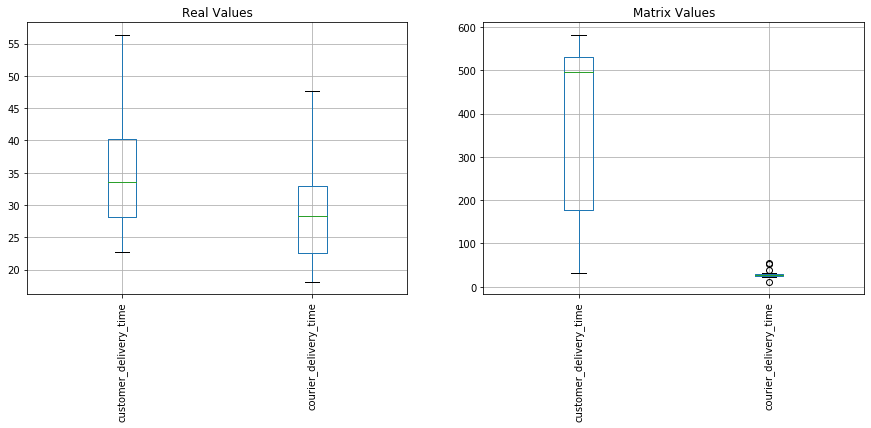

Real values: customer DT outliers


,order_id,customer_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,number_of_assignments
12,81904275,56.383333,0.100000,27.516667,1
20,81844788,56.216667,25.550000,0.016667,1
31,81846119,55.550000,9.850000,0.016667,1
25,81902218,48.033333,0.350000,0.016667,1
10,81844642,45.533333,0.133333,6.116667,1


Real values: courier DT outliers


,order_id,courier_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
25,81902218,47.633333,0.350000,0.016667,16.150000,8.900000,17.950000,4.616667
31,81846119,45.650000,9.850000,0.016667,16.300000,14.416667,9.383333,5.533333
3,81904756,42.866667,0.133333,0.016667,16.550000,6.066667,15.150000,5.083333
9,81903852,41.900000,0.966667,0.016667,5.633333,22.816667,9.533333,3.900000
10,81844642,39.266667,0.133333,6.116667,31.916667,1.366667,5.016667,0.933333


In [557]:
real_dt.columns

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
real_dt.boxplot(column=['customer_delivery_time', 'courier_delivery_time'], ax = ax1, rot = 90)
ax1.set_title('Real Values')

sim_dt.boxplot(column=['customer_delivery_time', 'courier_delivery_time'], ax = ax2, rot = 90)
ax2.set_title('Matrix Values')
plt.show()


outlier_validation_metrics = ['order_id', 'customer_delivery_time', 'activation_to_first_stacking', 
                              'first_stacking_to_courier_start', 'number_of_assignments']
print('Real values: customer DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('customer_delivery_time', ascending = False).head(5))



outlier_validation_metrics = ['order_id', 'courier_delivery_time', 'activation_to_first_stacking',
                              'first_stacking_to_courier_start', 'start_to_pickup_time', 'waiting_pickup_time',
                              'pickup_to_delivery_time', 'waiting_delivery_time']
print('Real values: courier DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('courier_delivery_time', ascending = False).head(5))

real_dt_original = real_dt

real_dt_reassignments = real_dt[real_dt.number_of_assignments > 1]
real_dt = real_dt[real_dt.number_of_assignments == 1]


waiting_delivery_time_boundary = real_dt.waiting_delivery_time.quantile(0.75) + 3 * iqr(real_dt.waiting_delivery_time)

real_dt_wtd_outlier = real_dt[real_dt.waiting_delivery_time > waiting_delivery_time_boundary]
real_dt = real_dt[real_dt.waiting_delivery_time <= waiting_delivery_time_boundary]



waiting_pickup_time_boundary = real_dt.waiting_pickup_time.quantile(0.75) + 3 * iqr(real_dt.waiting_pickup_time)

real_dt_wtp_outlier = real_dt[real_dt.waiting_pickup_time > waiting_pickup_time_boundary]
real_dt = real_dt[real_dt.waiting_pickup_time <= waiting_pickup_time_boundary]


dispatch_to_accept_time_boundary = real_dt.partner_dispatch_to_accept.quantile(0.75) + 3 * iqr(real_dt.partner_dispatch_to_accept)

real_dt_disp_to_accept_outlier = real_dt[real_dt.partner_dispatch_to_accept > dispatch_to_accept_time_boundary]
real_dt = real_dt[real_dt.partner_dispatch_to_accept <= dispatch_to_accept_time_boundary]

# sp distance
sp_distance_boundary = real_dt.start_to_pickup_distance.quantile(0.75) + 3 * iqr(real_dt.start_to_pickup_distance)

real_dt_sp_distance_outlier = real_dt[real_dt.start_to_pickup_distance > sp_distance_boundary]
real_dt = real_dt[real_dt.start_to_pickup_distance <= sp_distance_boundary]

## Cleaning outliers

For the moment, we have applied the following criterias to detect outliers, caused by phenomenas that we are not considering in our simulation. 

1. Orders that have been reassigned. 
2. Orders that have a waiting at pickup time higher than 3Q + 3IQR. 
3. Orders that have a waiting at delivery time higher than 3Q + 3IQR. 

These are quite conservative criterias. The number of cleaned orders by each of the criterias is the following:

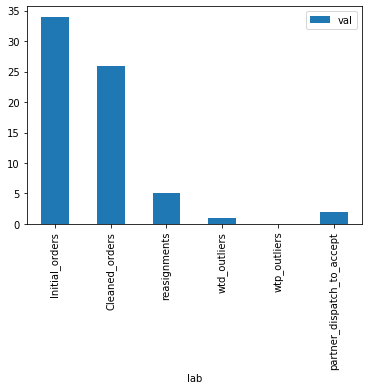

In [558]:

df = pd.DataFrame({'lab':['Initial_orders', 'Cleaned_orders', 'reasignments', 'wtd_outliers', 'wtp_outliers',
                         'partner_dispatch_to_accept'], 
                   'val':[len(real_dt_original), len(real_dt), len(real_dt_reassignments),
                          len(real_dt_wtd_outlier),len(real_dt_wtp_outlier), len(real_dt_disp_to_accept_outlier)]})

ax = df.plot.bar(x='lab', y='val', rot=90)




## Data after outlier cleansing

In [559]:

outlier_validation_metrics = ['order_id', 'customer_delivery_time', 'activation_to_first_stacking', 'first_stacking_to_courier_start', 'number_of_assignments']
display(real_dt[outlier_validation_metrics].sort_values('customer_delivery_time', ascending = False).head(5))


outlier_validation_metrics = ['order_id', 'courier_delivery_time', 'activation_to_first_stacking', 'first_stacking_to_courier_start', 'start_to_pickup_time', 'waiting_pickup_time', 'pickup_to_delivery_time', 'waiting_delivery_time']
print('Real values: courier DT outliers')
display(real_dt[outlier_validation_metrics].sort_values('courier_delivery_time', ascending = False).head(5))



,order_id,customer_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,number_of_assignments
12,81904275,56.383333,0.100000,27.516667,1
20,81844788,56.216667,25.550000,0.016667,1
31,81846119,55.550000,9.850000,0.016667,1
25,81902218,48.033333,0.350000,0.016667,1
10,81844642,45.533333,0.133333,6.116667,1


Real values: courier DT outliers


,order_id,courier_delivery_time,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
25,81902218,47.633333,0.350000,0.016667,16.150000,8.900000,17.950000,4.616667
31,81846119,45.650000,9.850000,0.016667,16.300000,14.416667,9.383333,5.533333
3,81904756,42.866667,0.133333,0.016667,16.550000,6.066667,15.150000,5.083333
9,81903852,41.900000,0.966667,0.016667,5.633333,22.816667,9.533333,3.900000
10,81844642,39.266667,0.133333,6.116667,31.916667,1.366667,5.016667,0.933333


## Incidents

In [590]:
# FILTER OUR INCIDENTS

incidents_summary = pd.read_csv("reality_data/incidences_summary_SEV_2019-12-01_2019-12-01.csv")
incidents_orders = pd.read_csv("reality_data/incidences_orders_SEV_2019-12-01_2019-12-01.csv")
                        

In [591]:
orders_intersection = pd.merge(incidents_orders[['order_id']], real_dt[['order_id']], how='inner')
orders_intersection = pd.merge(orders_intersection, sim_dt[['order_id']], how='inner')

#print("Number of common orders in matrix and reality:", len(orders_intersection))

#We keep only orders that are found on both matrix and reality.
sim_dt = pd.merge(sim_dt, orders_intersection, on = 'order_id', how = 'inner')
real_dt = pd.merge(real_dt, orders_intersection, on = 'order_id', how = 'inner')

In [592]:

real_dt_with_incidents = pd.merge(real_dt, incidents_orders, on = 'order_id', how = 'left')
real_dt = real_dt_with_incidents.loc[real_dt_with_incidents["Any_problem"]==False]

In [593]:
#len(real_dt)

In [594]:
incidents_summary

,Unnamed: 0,Order Type,val
0,0,Total,2789
1,1,Cancelled,484
2,2,Delivered,2305
3,3,Reassigned,164
4,4,Manual_Assignment,40
5,5,Orphan,69
6,6,Cancelled Reassignments,31
7,7,Orders_without_incidences,2067



# Customer Delivery Time

We will start by taking a look at the deviation of the CDT. At the same time, we will try which of the components of the CDT are the ones that have the biggest deviation. 

## Daily aggregation


In [595]:
def plot_time_comp_distr_and_hours(real_dt, sim_dt, metric):

    # check if dataframes non empty
    if len(real_dt)==0:
        print("Real data is empty")
        return
    if len(sim_dt)==0:
        print("Sim data is empty")
        return
    
    real_no_outl, real_outl = detect_outliers(real_dt[metric], q1, q2, th)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[metric], q1, q2, th)

    ## compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)
    
    diff_activation_time = get_overall_distr_by_hour(metric)
    
    
    # plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    ax1.set_title(metric)
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density= True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    #ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("time[min]")
    
    ax2.plot(diff_activation_time["activation_time_hour"], diff_activation_time["diff"], label=metric)
    ax2.set_xticks(diff_activation_time["activation_time_hour"])
    ax2.set_xlabel("hour")
    ax2.set_ylabel("difference (simulation - real) [min]")
    ax2.set_title("Difference between simulation and real data by hour")
    ax2.grid()
    ax2.legend()
    plt.show()

    
    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff(real_no_outl, sim_no_outl)

    # print statistics
    row_sim.append(row_real)

In [596]:
def plot_dist_comp_distr_and_hours(metric):

    
    real_no_outl, real_outl = detect_outliers(real_dt[metric], q1, q2, th)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[metric], q1, q2, th)

    ## compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)
    
    diff_activation_time = get_overall_distr_by_hour(metric)
    
    
    # plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    ax1.set_title(metric)
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density= True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("distance[m]")
    
    ax2.plot(diff_activation_time["activation_time_hour"], diff_activation_time["diff"], label=metric)
    ax2.set_xticks(diff_activation_time["activation_time_hour"])
    ax2.set_xlabel("hour")
    ax2.set_ylabel("difference (simulation - real) [m]")
    ax2.set_title("Difference between simulation and real data by hour")
    ax2.grid()
    ax2.legend()
    plt.show()

    
    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff_dist(real_no_outl, sim_no_outl)

    # print statistics
    row_sim.append(row_real)

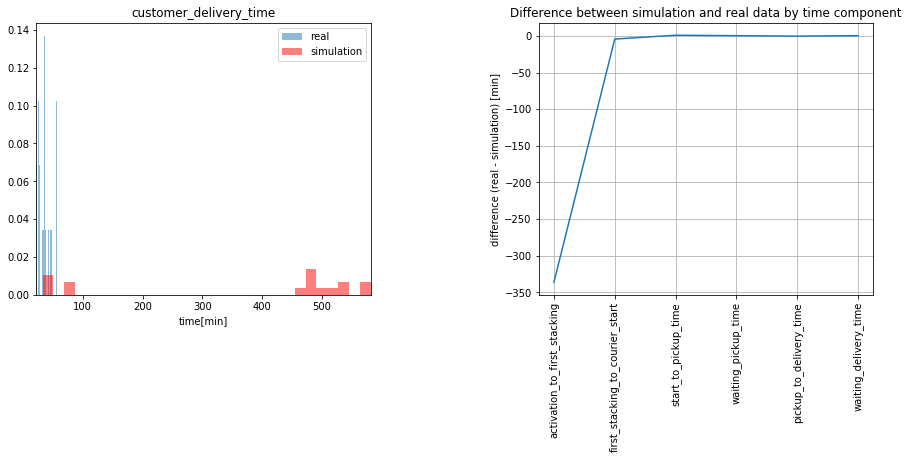

p-value = 0.00


$\Delta \mu = -333.34$ min [real - simulation]

,mean,std,outliers no,outliers %,q15,q85
sim,368.84,214.41,0,0.0,52.65,534.22
real,35.49,9.88,0,0.0,26.79,46.16


,activation_to_first_stacking,first_stacking_to_courier_start,start_to_pickup_time,waiting_pickup_time,pickup_to_delivery_time,waiting_delivery_time
real,3.953205,1.580128,10.425000,6.773077,9.425000,3.211538
sim,340.423718,5.875000,9.497368,6.448039,9.757843,2.847917
diff,-336.470513,-4.294872,0.927632,0.325038,-0.332843,0.363622


In [597]:
def plot_distr_by_day_with_comps(col, components):
    # plot by day

    # compute mean differences for each of the components metrics. 
    
    avg_diff = []
    for metric in components:
        diff =  real_dt.loc[:, metric].mean() - sim_dt.loc[:, metric].mean() 
        avg_diff.append(diff)

    # set percentiles
    q1 = 15
    q2 = 85

    # identify outliers
    real_no_outl, real_outl = detect_outliers(real_dt[col], q1, q2, 1.8)
    sim_no_outl, sim_outl = detect_outliers(sim_dt[col], q1, q2, 1.8)

    # compute statistics
    row_real = get_statistics(real_no_outl, real_outl, "real", q1, q2)
    row_sim = get_statistics(sim_no_outl, sim_outl, "sim", q1, q2)

    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    # plot distributions
    ax1.hist(real_no_outl, bins=30, label='real', alpha=0.5, density=True)
    ax1.hist(sim_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density= True)
    ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    ax1.legend()
    ax1.set_xlabel("time[min]")
    ax1.set_title(col)
 
    

    ax2.plot(np.arange(len(avg_diff)), avg_diff)
    ax2.set_xticks(np.arange(len(avg_diff)))
    ax2.set_xticklabels(components, rotation='vertical')
    ax2.set_ylabel("difference (real - simulation) [min]")
    ax2.set_title("Difference between simulation and real data by time component")
    ax2.grid()
    
    plt.show()

    # compute ks test
    kstat, p_value = ks_2samp(sim_no_outl, real_no_outl)
    print("p-value = %.2f" %p_value)

    # print the difference between mean of two distributions
    print_avg_diff(real_dt[col], sim_dt[col])
    
    # print statistics
    display(row_sim.append(row_real))
    
    

    
plot_distr_by_day_with_comps(time, time_components)

real_means = real_dt[time_components].apply(np.mean, axis = 0)
sim_means = sim_dt[time_components].apply(np.mean, axis = 0)
summary_real_sim = pd.DataFrame({'real': real_means, 'sim':sim_means})
summary_real_sim['diff'] = summary_real_sim.real - summary_real_sim.sim
summary_real_sim = summary_real_sim.T

summary_real_sim = summary_real_sim[['activation_to_first_stacking', 'first_stacking_to_courier_start',
       'start_to_pickup_time', 'waiting_pickup_time','pickup_to_delivery_time',
        'waiting_delivery_time']]


display(summary_real_sim)



In [598]:
sim_dt.head()

,activation_time,courier_starts_order,order_id,partner_dispatch_to_enter_pickup,activation_to_partner_dispatch,waiting_delivery_time,pickup_to_delivery_time,food_getting_cold,waiting_pickup_time,start_to_pickup_time,last_stacking_to_courier_start,first_stacking_to_last_stacking,activation_to_first_stacking,customer_delivery_time,courier_delivery_time,first_stacking_to_courier_start,activation_time_date,activation_time_hour,order_category,prioritized_pickup
0,1900-01-01 00:00:31,09:52:00,81844642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,591.483333,NaN,NaN,0.0,1900-01-01,0,WALL - Partner,False
1,1900-01-01 00:01:32,08:35:00,81844788.0,862.0,30301.0,2.616667,12.716667,0.0,0.633333,5.916667,720.0,0.0,501.466667,535.350000,21.883333,12.0,1900-01-01,0,WALL - Partner,False
2,1900-01-01 00:03:47,00:08:00,81845121.0,503.0,253.0,3.266667,10.333333,0.0,6.616667,8.383333,0.0,0.0,4.216667,32.816667,28.600000,0.0,1900-01-01,0,WALL - Partner,False
3,1900-01-01 00:05:41,09:58:00,81845420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,0.0,580.316667,NaN,NaN,12.0,1900-01-01,0,WALL - Partner,False
4,1900-01-01 00:06:17,09:47:00,81845509.0,NaN,35541.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,580.716667,NaN,NaN,0.0,1900-01-01,0,WALL - Partner,False


## Analysis by order category

In [599]:
def plot_distr_by_day_with_order_category(col, components):
    
    # TODO: remove - should be already in the data (or add to the script)
    sim_dt["order_category"] = 'WALL - Partner'
    sim_dt["prioritized_pickup"] = False
    
    # compute number of orders per category
   
    
    r_partner=real_dt.loc[real_dt['order_category'] == 'WALL - Partner']["order_id"].count()
    r_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")]["order_id"].count()
    r_pp=real_dt.loc[(real_dt['prioritized_pickup'] == True)]["order_id"].count()
    
    orders_real_count = pd.DataFrame({'Partner Normal': r_partner - r_pp,
                                                   'Partner PP': r_pp,
                                                  'F/Q/S': r_fqs}, 
                                    index=[0])
 
    s_partner=sim_dt.loc[sim_dt['order_category'] == 'WALL - Partner']["order_id"].count()
    s_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")]["order_id"].count()
    s_pp=sim_dt.loc[(sim_dt['prioritized_pickup'] == True)]["order_id"].count()
    
    orders_sim_count = pd.DataFrame({'Partner Normal': s_partner - s_pp,
                                                   'Partner PP': s_pp,
                                                  'F/Q/S': s_fqs},
                                   index=[0])
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    
    # plot distributions
    x = np.arange(orders_real_count.shape[1])  # the label locations
    width = 0.3  # the width of the bars

    rects1 = ax1.bar(x - width/2, orders_real_count.values[0], width, alpha=0.5, label='real')
    rects2 = ax1.bar(x + width/2, orders_sim_count.values[0], width, color='r', alpha=0.5, label='sim')

    # Add some text for labels, title and custom x-axis tick labels, etc.

    ax1.set_xticks(x)
    ax1.set_xticklabels(orders_real_count.columns, rotation='vertical')
    ax1.legend()
    
    #real_dt['order_category'].value_counts().plot(kind='bar', ax=ax1)
   # ax1.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
    #ax1.set_xlabel("order category")
    ax1.set_title("Number of orders per category")
 
    # compute mean differences for each of the components metrics. 
    
    r_avg_partner=real_dt.loc[(real_dt['order_category'] == 'WALL - Partner')
                             | (real_dt['prioritized_pickup'] != True)][col].mean()
    r_avg_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")][col].mean()
    r_pp=real_dt.loc[(real_dt['prioritized_pickup'] == True)][col].mean()
    
 
    s_avg_partner=sim_dt.loc[(sim_dt['order_category'] == 'WALL - Partner')
                             | (sim_dt['prioritized_pickup'] != True)][col].mean()
    s_avg_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")][col].mean()
    s_pp=sim_dt.loc[(sim_dt['prioritized_pickup'] == True)][col].mean()
    

    avg_diff = [r_avg_partner - s_avg_partner, r_avg_fqs - s_avg_fqs, r_pp - s_pp]
    ax2.plot(np.arange(len(avg_diff)), avg_diff, "*")
    ax2.set_xticks(np.arange(len(avg_diff)))
    ax2.set_xticklabels(orders_real_count.columns, rotation='vertical')
    ax2.set_ylabel("difference (real - simulation) [min]")
    ax2.set_title("Difference between simulation and real data by order category")
    ax2.grid()
    
    plt.show()

category_list = ["Partner", "F/Q/S", "prioritized_pickup"]

plot_distr_by_day_with_order_category("customer_delivery_time", category_list)


KeyError: 'order_category'

### Partner Orders Normal (non PP)

In [600]:
#percentiles
q1 = 10
q2 = 90
th = 2
   
real_dt_partner=real_dt.loc[(real_dt['order_category'] == 'WALL - Partner')
                             | (real_dt['prioritized_pickup'] != True)]
sim_dt_partner=sim_dt.loc[(sim_dt['order_category'] == 'WALL - Partner')
                             | (sim_dt['prioritized_pickup'] != True)]

plot_time_comp_distr_and_hours(real_dt_partner, sim_dt_partner, 'customer_delivery_time')

KeyError: 'order_category'

### Partner Orders Prioritized Pickup

In [601]:
#percentiles
q1 = 5
q2 = 95
th = 2
   
real_dt_pp=real_dt.loc[real_dt['prioritized_pickup'] == True]
sim_dt_pp=sim_dt.loc[sim_dt['prioritized_pickup'] == True]

plot_time_comp_distr_and_hours(real_dt_pp, sim_dt_pp, 'customer_delivery_time')

Sim data is empty


### Fake/Quiero/Shipment

In [602]:
#percentiles
q1 = 5
q2 = 95
th = 2

    
real_dt_fqs=real_dt.loc[(real_dt['order_category'] == "WALL - NonPartner") |
                      (real_dt['order_category'] == "COURIER") |
                      (real_dt['order_category'] == "QUIERO")]
  
sim_dt_fqs=sim_dt.loc[(sim_dt['order_category'] == "WALL - NonPartner") |
                      (sim_dt['order_category'] == "COURIER") |
                      (sim_dt['order_category'] == "QUIERO")]

plot_time_comp_distr_and_hours(real_dt_fqs, sim_dt_fqs, 'customer_delivery_time')

KeyError: 'order_category'

## Customer DT components analysis

In this section, we will look at each of the components of the CDT

### Activation to first stacked

#### General overview



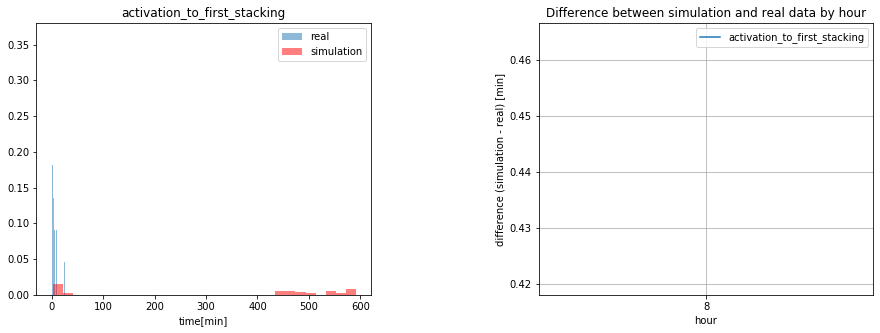

p-value = 0.00


$\Delta \mu = -336.47$ min [real - simulation]

In [603]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'activation_to_first_stacking')

#### Edge cases review

In [604]:
fields = ['order_id', 'activation_to_first_stacking', 'activation_time']

#sim_dt.columns

sim_real_activation_first_stack = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_activation_first_stack['sim_real_activation_first_stack_gap'] = sim_real_activation_first_stack.activation_to_first_stacking_x - sim_real_activation_first_stack.activation_to_first_stacking_y

sim_real_activation_first_stack = sim_real_activation_first_stack.sort_values('sim_real_activation_first_stack_gap', ascending = False)

sim_real_activation_first_stack.head(10)

,order_id,activation_to_first_stacking_x,activation_time_x,activation_to_first_stacking_y,activation_time_y,sim_real_activation_first_stack_gap
12,81846132,5.650000,2019-11-30 23:10:15,2.750000,1900-01-01 00:10:15,2.900000
16,81845121,3.983333,2019-11-30 23:03:47,4.216667,1900-01-01 00:03:47,-0.233333
1,81906523,0.700000,2019-12-01 08:52:50,3.166667,1900-01-01 09:52:50,-2.466667
0,81901831,0.383333,2019-12-01 07:25:41,6.316667,1900-01-01 08:25:41,-5.933333
18,81902218,0.350000,2019-12-01 07:37:55,7.083333,1900-01-01 08:37:55,-6.733333
25,81848717,4.050000,2019-11-30 23:26:05,17.916667,1900-01-01 00:26:05,-13.866667
2,81904756,0.133333,2019-12-01 08:26:57,19.050000,1900-01-01 09:26:57,-18.916667
10,81904275,0.100000,2019-12-01 08:19:51,20.150000,1900-01-01 09:19:51,-20.050000
7,81903852,0.966667,2019-12-01 08:13:54,27.100000,1900-01-01 09:13:54,-26.133333
17,81848029,8.966667,2019-11-30 23:22:11,449.816667,1900-01-01 00:22:11,-440.850000


### First stacked to started

#### General overview


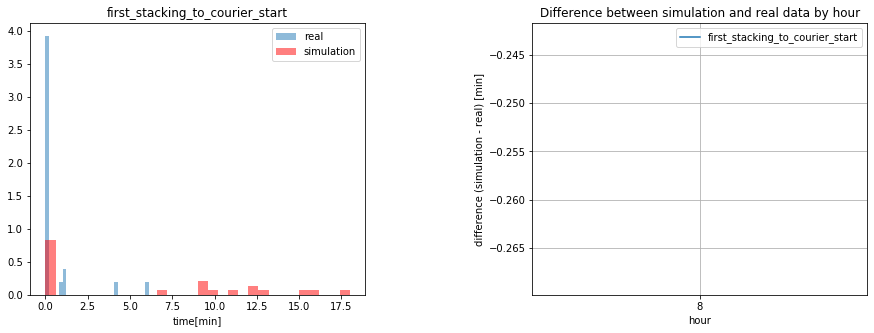

p-value = 0.00


$\Delta \mu = -5.33$ min [real - simulation]

In [605]:

#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'first_stacking_to_courier_start')



#### Edge cases review

In [606]:
fields = ['order_id', 'first_stacking_to_courier_start']

#sim_dt.columns

sim_real_first_stack_courier_start = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_first_stack_courier_start['sim_real_first_stacking_courier_start_gap'] = sim_real_first_stack_courier_start.first_stacking_to_courier_start_x - sim_real_first_stack_courier_start.first_stacking_to_courier_start_y

sim_real_first_stack_courier_start = sim_real_first_stack_courier_start.sort_values('sim_real_first_stacking_courier_start_gap', ascending = False)


display(sim_real_first_stack_courier_start.head(10))
display(sim_real_first_stack_courier_start.tail(10))

real_dt.first_stacking_to_courier_start.describe()

,order_id,first_stacking_to_courier_start_x,first_stacking_to_courier_start_y,sim_real_first_stacking_courier_start_gap
10,81904275,27.516667,10.0,17.516667
8,81844642,6.116667,0.0,6.116667
17,81848029,1.033333,0.0,1.033333
9,81845875,1.033333,0.0,1.033333
12,81846132,1.016667,0.0,1.016667
4,81846239,0.033333,0.0,0.033333
21,81847486,0.033333,0.0,0.033333
6,81847895,0.016667,0.0,0.016667
16,81845121,0.016667,0.0,0.016667
24,81848113,0.016667,0.0,0.016667


,order_id,first_stacking_to_courier_start_x,first_stacking_to_courier_start_y,sim_real_first_stacking_courier_start_gap
25,81848717,0.000000,9.0,-9.000000
7,81903852,0.016667,11.0,-10.983333
14,81844788,0.016667,12.0,-11.983333
20,81845420,0.016667,12.0,-11.983333
19,81845742,0.016667,13.0,-12.983333
13,81850452,0.000000,15.0,-15.000000
0,81901831,0.016667,16.0,-15.983333
23,81846119,0.016667,18.0,-17.983333
1,81906523,4.100000,NaN,NaN
2,81904756,0.016667,NaN,NaN


count    26.000000
mean      1.580128
std       5.475941
min       0.000000
25%       0.016667
50%       0.016667
75%       0.033333
max      27.516667
Name: first_stacking_to_courier_start, dtype: float64

### Started to enters pickup

#### General overview

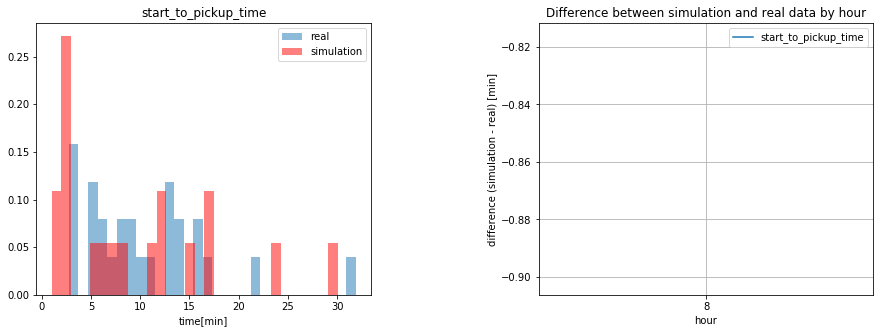

p-value = 0.14


$\Delta \mu = 0.93$ min [real - simulation]

In [607]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'start_to_pickup_time')

#### Edge cases review

In [608]:
fields = ['order_id', 'start_to_pickup_time']

#sim_dt.columns

sim_real_start_to_pickup_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_start_to_pickup_time['sim_real_start_to_pickup_time_gap'] = \
sim_real_start_to_pickup_time.start_to_pickup_time_x - sim_real_start_to_pickup_time.start_to_pickup_time_y

sim_real_start_to_pickup_time= sim_real_start_to_pickup_time.sort_values('sim_real_start_to_pickup_time_gap', ascending = False)


display(sim_real_start_to_pickup_time.head(10))
display(sim_real_start_to_pickup_time.tail(10))

real_dt.start_to_pickup_time.describe()

,order_id,start_to_pickup_time_x,start_to_pickup_time_y,sim_real_start_to_pickup_time_gap
21,81847486,12.750000,2.783333,9.966667
0,81901831,14.000000,5.400000,8.600000
10,81904275,10.933333,2.700000,8.233333
5,81848731,8.266667,1.016667,7.250000
23,81846119,16.300000,11.166667,5.133333
17,81848029,4.800000,1.016667,3.783333
9,81845875,5.166667,2.300000,2.866667
7,81903852,5.633333,2.900000,2.733333
18,81902218,16.150000,15.350000,0.800000
6,81847895,3.033333,2.900000,0.133333


,order_id,start_to_pickup_time_x,start_to_pickup_time_y,sim_real_start_to_pickup_time_gap
19,81845742,3.116667,11.683333,-8.566667
25,81848717,7.233333,23.566667,-16.333333
12,81846132,2.766667,30.066667,-27.300000
1,81906523,9.966667,NaN,NaN
2,81904756,16.550000,NaN,NaN
4,81846239,13.050000,NaN,NaN
8,81844642,31.916667,NaN,NaN
15,81845509,21.800000,NaN,NaN
20,81845420,13.683333,NaN,NaN
24,81848113,7.716667,NaN,NaN


count    26.000000
mean     10.425000
std       6.657045
min       2.766667
25%       5.679167
50%       8.816667
75%      13.562500
max      31.916667
Name: start_to_pickup_time, dtype: float64

#### SP distance

In [609]:
def calculate_velocity(df, time_col, dist_col):
    
    # calculate the velocity as distance/time
    df.loc[:, "velocity"] = df.loc[:, dist_col]/df.loc[:, time_col]
    
    # remove negative time predictions with <=0 s (cannot compute the velocity these cases )
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, time_col] >5,0)
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, dist_col] >1,0)
    df.loc[:, "velocity"] = df.loc[:, "velocity"].where(df.loc[:, "velocity"] < 3*10**5,0)
    
    return df.loc[:, "velocity"]
    

In [610]:
col = 'start_to_pickup_distance'

#percentiles
q1 = 10
q2 = 75
th = 2

plot_dist_comp_distr_and_hours(col)

KeyError: 'start_to_pickup_distance'

#### SP velocity

Overall distribution of velocity computed as sp distance/sp time.

In [611]:
real_dt.loc[:, "sp_velocity"]= calculate_velocity(real_dt, "start_to_pickup_time", "start_to_pickup_distance")
sim_dt.loc[:, "sp_velocity"]= calculate_velocity(sim_dt, "start_to_pickup_time", "start_to_pickup_distance")


KeyError: 'start_to_pickup_distance'

In [612]:

tmp = real_dt.copy()
tmp = tmp[tmp.velocity !=0]


data1 = tmp.loc[:, "start_to_pickup_distance"]
data2 = tmp.loc[:, "sp_velocity"]

tmp1 = sim_dt.copy()
tmp1 = tmp1[tmp1.velocity !=0]


# plot distributions

plt.subplots(figsize=(6.5,5))

plt.title("Velocity distribution")

plt.hist(tmp["sp_velocity"], label='real', alpha=0.5, density= True)
plt.hist(tmp1["sp_velocity"], color='r', label='simulation', alpha=0.5, density= True)
#ax.set_xlim((min(min(real_no_outl), min(sim_no_outl)), max(max(real_no_outl), max(sim_no_outl))))
plt.legend()
plt.xlabel("velocity[m/s]")
plt.show()


AttributeError: 'DataFrame' object has no attribute 'velocity'

Below we check the dependence between velocity and distance. Comparing the real and simulation data we can check if we take into account the correlation during the simulation process.

No handles with labels found to put in legend.


KeyError: 'start_to_pickup_distance'

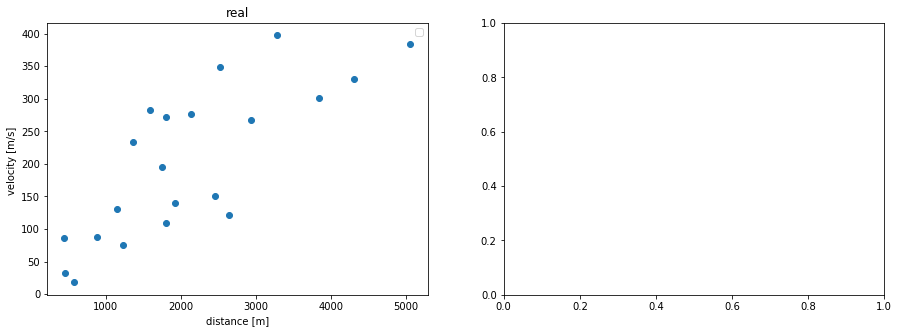

In [613]:
def create_colors_dict(data):
    c=["m","c","g","r","b"]
    colors = {}
    for transport in data["transport"].unique():
        colors[transport] = c.pop()
    return colors
    
colors=create_colors_dict(tmp)
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.title("real")
plt.scatter(data1, data2)
#plt.scatter(data1, data2, c=tmp['transport'].apply(lambda x: colors[x]), 
#            label=list(tmp["transport"].unique()))
#plt.legend(list(tmp["transport"].unique()))

plt.legend()

plt.xlabel("distance [m]")
plt.ylabel("velocity [m/s] ")

data1 = tmp1.loc[:, "start_to_pickup_distance"]
data2 = tmp1.loc[:, "sp_velocity"]

#colors=create_colors_dict(tmp1)
# plot
plt.subplot(1,2,2)
plt.title("simulation")
#plt.scatter(data1, data2, c=tmp1['transport'].apply(lambda x: colors[x]))
plt.scatter(data1, data2)
plt.xlabel("distance [m]")
plt.ylabel("velocity [m/s] ")
plt.suptitle("Velocity vs distance")
plt.show()

plt.show()

### Waiting time at pickup

#### General overview


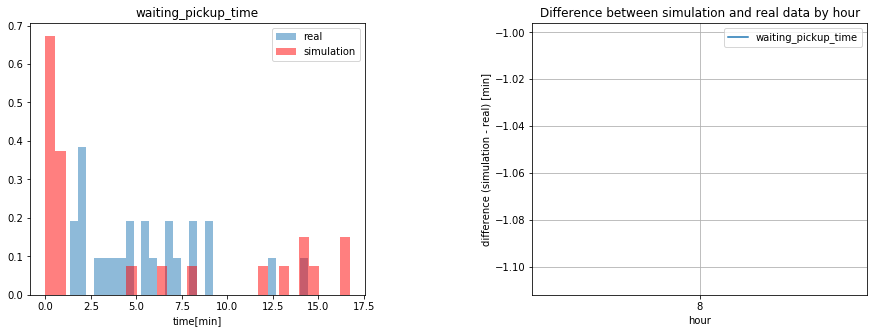

p-value = 0.00


$\Delta \mu = 0.34$ min [real - simulation]

In [580]:

#percentiles
q1 = 10
q2 = 75
th = 1.5

plot_time_comp_distr_and_hours(real_dt, sim_dt,'waiting_pickup_time')



#### Edge cases review

In [581]:
fields = ['order_id', 'waiting_pickup_time']

#sim_dt.columns

sim_real_waiting_pickup_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_waiting_pickup_time['sim_real_waiting_pickup_time_gap'] = \
sim_real_waiting_pickup_time.waiting_pickup_time_x - sim_real_waiting_pickup_time.waiting_pickup_time_y

sim_real_waiting_pickup_time= sim_real_waiting_pickup_time.sort_values('sim_real_waiting_pickup_time_gap', ascending = False)


display(sim_real_waiting_pickup_time.head(10))
display(sim_real_waiting_pickup_time.tail(10))

real_dt.waiting_pickup_time.describe()

,order_id,waiting_pickup_time_x,waiting_pickup_time_y,sim_real_waiting_pickup_time_gap
19,81845742,19.916667,0.000000,19.916667
23,81846119,14.416667,0.683333,13.733333
14,81844788,12.316667,0.633333,11.683333
12,81846132,8.100000,0.000000,8.100000
22,81849545,7.050000,0.000000,7.050000
11,81850690,5.683333,0.000000,5.683333
0,81901831,2.183333,0.016667,2.166667
5,81848731,6.866667,4.983333,1.883333
13,81850452,1.983333,0.333333,1.650000
3,81848892,6.733333,7.983333,-1.250000


,order_id,waiting_pickup_time_x,waiting_pickup_time_y,sim_real_waiting_pickup_time_gap
25,81848717,2.216667,16.516667,-14.3
1,81906523,3.166667,NaN,NaN
2,81904756,6.066667,NaN,NaN
4,81846239,4.750000,NaN,NaN
7,81903852,22.816667,NaN,NaN
8,81844642,1.366667,NaN,NaN
10,81904275,8.150000,NaN,NaN
15,81845509,1.683333,NaN,NaN
20,81845420,3.016667,NaN,NaN
24,81848113,3.633333,NaN,NaN


count    26.000000
mean      6.773077
std       5.405113
min       1.366667
25%       3.054167
50%       5.583333
75%       8.137500
max      22.816667
Name: waiting_pickup_time, dtype: float64

### Pickup to delivery time

#### General overview

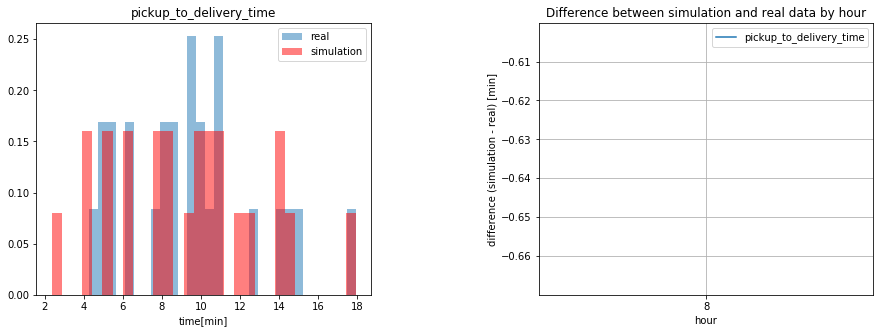

p-value = 1.00


$\Delta \mu = 0.11$ min [real - simulation]

In [582]:
#percentiles
q1 = 10
q2 = 90
th = 2

plot_time_comp_distr_and_hours(real_dt, sim_dt,'pickup_to_delivery_time')

#### Edge cases review

In [583]:
fields = ['order_id', 'pickup_to_delivery_time']

#sim_dt.columns

sim_real_pickup_to_delivery_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_pickup_to_delivery_time['sim_real_pickup_to_delivery_time_gap'] = \
sim_real_pickup_to_delivery_time.pickup_to_delivery_time_x - sim_real_pickup_to_delivery_time.pickup_to_delivery_time_y

sim_real_pickup_to_delivery_time= sim_real_pickup_to_delivery_time.sort_values('sim_real_pickup_to_delivery_time_gap', ascending = False)


display(sim_real_pickup_to_delivery_time.head(10))
display(sim_real_pickup_to_delivery_time.tail(10))

real_dt.pickup_to_delivery_time.describe()

,order_id,pickup_to_delivery_time_x,pickup_to_delivery_time_y,sim_real_pickup_to_delivery_time_gap
0,81901831,14.183333,14.183333,0.0
16,81845121,10.333333,10.333333,0.0
23,81846119,9.383333,9.383333,0.0
22,81849545,9.683333,9.683333,0.0
21,81847486,10.883333,10.883333,0.0
19,81845742,7.866667,7.866667,0.0
18,81902218,17.950000,17.950000,0.0
17,81848029,8.066667,8.066667,0.0
14,81844788,12.716667,12.716667,0.0
3,81848892,5.350000,5.350000,0.0


,order_id,pickup_to_delivery_time_x,pickup_to_delivery_time_y,sim_real_pickup_to_delivery_time_gap
25,81848717,10.983333,10.983333,0.0
1,81906523,10.150000,NaN,NaN
2,81904756,15.150000,NaN,NaN
4,81846239,8.583333,NaN,NaN
7,81903852,9.533333,NaN,NaN
8,81844642,5.016667,NaN,NaN
10,81904275,6.250000,NaN,NaN
15,81845509,5.016667,NaN,NaN
20,81845420,8.683333,NaN,NaN
24,81848113,10.783333,NaN,NaN


count    26.000000
mean      9.425000
std       3.449262
min       4.283333
25%       6.654167
50%       9.458333
75%      10.858333
max      17.950000
Name: pickup_to_delivery_time, dtype: float64

### Waiting time at delivery

#### General overview

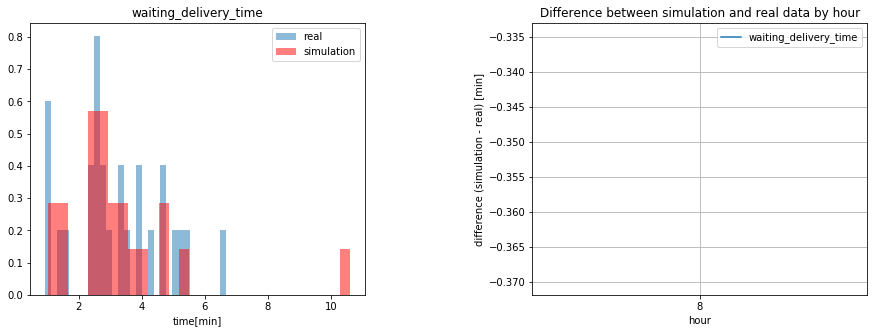

p-value = 0.98


$\Delta \mu = -0.03$ min [real - simulation]

In [584]:
col = 'waiting_delivery_time'

plot_time_comp_distr_and_hours(real_dt, sim_dt, col)

#### Edge cases review

In [585]:
fields = ['order_id', 'waiting_delivery_time']

#sim_dt.columns

sim_real_waiting_delivery_time = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_waiting_delivery_time['sim_real_waiting_delivery_time_gap'] = \
sim_real_waiting_delivery_time.waiting_delivery_time_x - sim_real_waiting_delivery_time.waiting_delivery_time_y

sim_real_waiting_delivery_time= sim_real_waiting_delivery_time.sort_values('sim_real_waiting_delivery_time_gap', ascending = False)


display(sim_real_waiting_delivery_time.head(10))
display(sim_real_waiting_delivery_time.tail(10))

real_dt.waiting_delivery_time.describe()

,order_id,waiting_delivery_time_x,waiting_delivery_time_y,sim_real_waiting_delivery_time_gap
0,81901831,4.716667,4.716667,0.0
3,81848892,2.500000,2.500000,0.0
5,81848731,1.016667,1.016667,0.0
6,81847895,5.183333,5.183333,0.0
9,81845875,1.366667,1.366667,0.0
11,81850690,2.733333,2.733333,0.0
12,81846132,2.800000,2.800000,0.0
13,81850452,2.583333,2.583333,0.0
14,81844788,2.616667,2.616667,0.0
16,81845121,3.266667,3.266667,0.0


,order_id,waiting_delivery_time_x,waiting_delivery_time_y,sim_real_waiting_delivery_time_gap
1,81906523,3.933333,NaN,NaN
2,81904756,5.083333,NaN,NaN
4,81846239,1.650000,NaN,NaN
7,81903852,3.900000,NaN,NaN
8,81844642,0.933333,NaN,NaN
10,81904275,3.383333,NaN,NaN
15,81845509,2.483333,NaN,NaN
20,81845420,4.350000,NaN,NaN
23,81846119,5.533333,NaN,NaN
24,81848113,6.683333,NaN,NaN


count    26.000000
mean      3.211538
std       1.490822
min       0.933333
25%       2.420833
50%       2.841667
75%       4.245833
max       6.683333
Name: waiting_delivery_time, dtype: float64

# Courier Delivery Time

## Daily aggregation

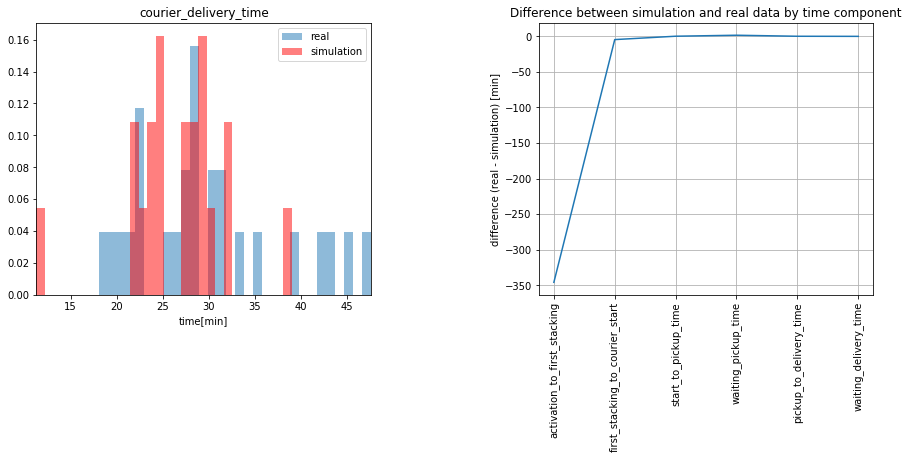

p-value = 0.30


$\Delta \mu = 0.83$ min [real - simulation]

,mean,std,outliers no,outliers %,q15,q85
sim,26.61,5.37,2,9.09,22.70,30.44
real,29.94,7.88,0,0.00,22.23,39.92


In [586]:
col = 'courier_delivery_time'

plot_distr_by_day_with_comps(col, time_components)

# Partner Metrics

## Activation to partner dispatch

### General overwiev

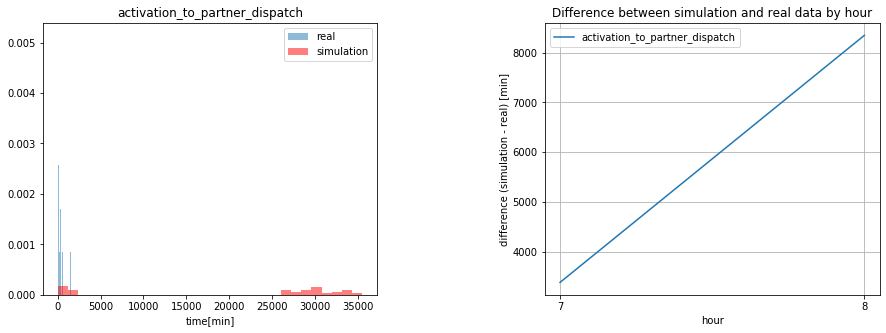

p-value = 0.00


$\Delta \mu = -20998.61$ min [real - simulation]

In [432]:
col = 'activation_to_partner_dispatch'

plot_time_comp_distr_and_hours(real_dt, sim_dt, col)

### Edge cases review

In [433]:
fields = ['order_id', 'activation_to_partner_dispatch']

#sim_dt.columns

sim_real_activation_to_partner_dispatch = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_activation_to_partner_dispatch['sim_real_activation_to_partner_dispatch_gap'] = \
sim_real_activation_to_partner_dispatch.activation_to_partner_dispatch_x - sim_real_activation_to_partner_dispatch.activation_to_partner_dispatch_y

sim_real_activation_to_partner_dispatch= sim_real_activation_to_partner_dispatch.sort_values('sim_real_activation_to_partner_dispatch_gap', ascending = False)


display(sim_real_activation_to_partner_dispatch.head(10))
display(sim_real_activation_to_partner_dispatch.tail(10))

real_dt.activation_to_partner_dispatch.describe()

,order_id,activation_to_partner_dispatch_x,activation_to_partner_dispatch_y,sim_real_activation_to_partner_dispatch_gap
13,81845121,257,253.0,4.0
0,81901831,34,764.0,-730.0
9,81846132,344,1078.0,-734.0
15,81902218,39,891.0,-852.0
7,81904275,22,1209.0,-1187.0
22,81848717,250,2034.0,-1784.0
14,81848029,546,26989.0,-26443.0
18,81847486,127,26762.0,-26635.0
1,81848892,25,26938.0,-26913.0
6,81845875,75,27503.0,-27428.0


,order_id,activation_to_partner_dispatch_x,activation_to_partner_dispatch_y,sim_real_activation_to_partner_dispatch_gap
8,81850690,104,29457.0,-29353.0
10,81850452,65,30196.0,-30131.0
4,81847895,351,32499.0,-32148.0
20,81846119,607,33666.0,-33059.0
16,81845742,158,33391.0,-33233.0
21,81848113,584,33931.0,-33347.0
12,81845509,286,35541.0,-35255.0
2,81846239,75,NaN,NaN
5,81844642,15,NaN,NaN
17,81845420,275,NaN,NaN


count      23.000000
mean      276.739130
std       331.093535
min        15.000000
25%        70.000000
50%       185.000000
75%       347.500000
max      1540.000000
Name: activation_to_partner_dispatch, dtype: float64

## Partner dispatch to enter pickup

### General overwiev

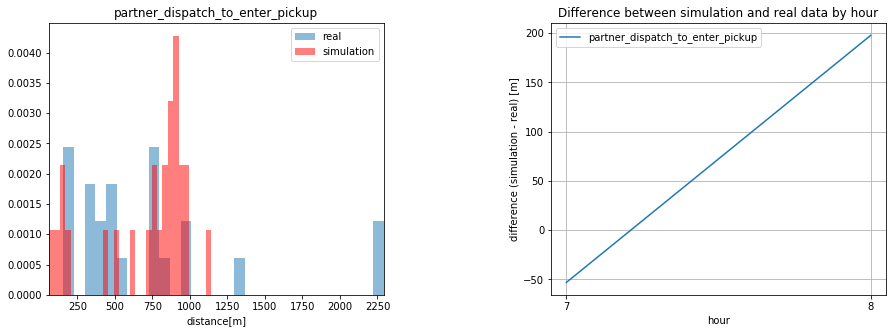

p-value = 0.12


$\Delta \mu = 10.78$ m [real - simulation]

In [434]:
col = 'partner_dispatch_to_enter_pickup'

plot_dist_comp_distr_and_hours(col)

### Edge cases review

In [435]:
fields = ['order_id', 'partner_dispatch_to_enter_pickup']

#sim_dt.columns

sim_real_partner_dispatch_to_enter_pickup = pd.merge(real_dt[fields], sim_dt[fields], how = "inner", on = "order_id")
sim_real_partner_dispatch_to_enter_pickup['sim_real_partner_dispatch_to_enter_pickup_gap'] = \
sim_real_partner_dispatch_to_enter_pickup.partner_dispatch_to_enter_pickup_x - sim_real_partner_dispatch_to_enter_pickup.partner_dispatch_to_enter_pickup_y

sim_real_partner_dispatch_to_enter_pickup= sim_real_partner_dispatch_to_enter_pickup.sort_values('sim_real_partner_dispatch_to_enter_pickup_gap', ascending = False)


display(sim_real_partner_dispatch_to_enter_pickup.head(10))
display(sim_real_partner_dispatch_to_enter_pickup.tail(10))

real_dt.partner_dispatch_to_enter_pickup.describe()

,order_id,partner_dispatch_to_enter_pickup_x,partner_dispatch_to_enter_pickup_y,sim_real_partner_dispatch_to_enter_pickup_gap
7,81904275,2292,762.0,1530.0
18,81847486,762,167.0,595.0
14,81848029,343,61.0,282.0
6,81845875,369,138.0,231.0
20,81846119,965,837.0,128.0
4,81847895,178,174.0,4.0
15,81902218,954,995.0,-41.0
1,81848892,377,421.0,-44.0
0,81901831,832,899.0,-67.0
10,81850452,781,880.0,-99.0


,order_id,partner_dispatch_to_enter_pickup_x,partner_dispatch_to_enter_pickup_y,sim_real_partner_dispatch_to_enter_pickup_gap
8,81850690,507,900.0,-393.0
22,81848717,429,995.0,-566.0
9,81846132,224,891.0,-667.0
11,81844788,172,862.0,-690.0
16,81845742,156,927.0,-771.0
2,81846239,768,NaN,NaN
5,81844642,2276,NaN,NaN
12,81845509,1296,NaN,NaN
17,81845420,795,NaN,NaN
21,81848113,451,NaN,NaN


count      23.000000
mean      707.739130
std       577.770812
min       156.000000
25%       356.000000
50%       507.000000
75%       813.500000
max      2292.000000
Name: partner_dispatch_to_enter_pickup, dtype: float64

# The distribution by hour

The picture below shows the difference between the average delivery time in each hour for simulation and real data. 
We penalize by setting weights the hours where we don't have enough data to make any conclusions (In such cases the average from too few records is not giving a relevant information about the distribution).

The measure of importance is defined as below:
$f(h)= |n_h^{sim} * {avg}_h^{sim} - n_h^{real} * avg_h^{real}|$

By looking on the peak values we can investigate the hours where we can expect some significant differences between the distributions.

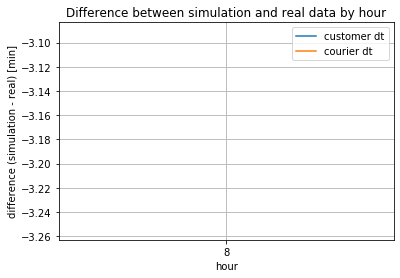

In [587]:
diff_dt_customer = get_overall_distr_by_hour("customer_delivery_time")
diff_dt_courier = get_overall_distr_by_hour("courier_delivery_time")

# plot the difference
fig= plt.figure()
ax = fig.gca()
plt.plot(diff_dt_customer["activation_time_hour"], diff_dt_customer["diff"], label="customer dt")
plt.plot(diff_dt_courier["activation_time_hour"], diff_dt_courier["diff"], label="courier dt")
ax.set_xticks(diff_dt_courier["activation_time_hour"])
plt.xlabel("hour")
plt.ylabel("difference (simulation - real) [min]")
plt.title("Difference between simulation and real data by hour")
plt.grid()
plt.legend()
plt.show()

## Customer Delivery Time

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


 hour: **8**

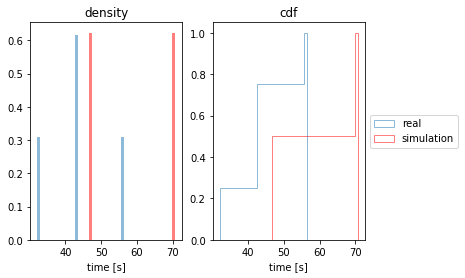

$\Delta \mu = -15.08$ min [real - simulation]

weighted $\Delta \mu = -3.25$ min [real - simulation]

,mean,std,outliers no,outliers %,q20,q80
sim,58.68,12.04,0,0.0,51.45,65.90
real,43.59,8.63,0,0.0,38.56,48.37


In [588]:
## by hour

col = 'customer_delivery_time'
def plot_distribution_for_each_hour(col):
    # percentiles
    q1 = 20
    q2 = 80
    th = 1.8
    diff_dt = get_overall_distr_by_hour(col)
    # sort dataframe by difference
    res = diff_dt[["activation_time_hour", "diff"]]
    res.loc[:,"abs_diff"] = abs(res.loc[:,"diff"])
    res = res.sort_values(by="abs_diff", ascending=False)[:5]

    # make the plot for each hour
    for hour in res["activation_time_hour"]:
        diff = round(res.loc[res["activation_time_hour"]==hour, "diff"].values[0],2)
    
        # filter by hour
        sim_dt_per_hour = sim_dt.loc[sim_dt["activation_time_hour"] == hour]
        real_dt_per_hour = real_dt.loc[real_dt["activation_time_hour"] == hour]

        # save plots distribution
        if (len(sim_dt_per_hour) > 0 and len(real_dt_per_hour) > 0):
            printmd(rf""" hour: **{hour}**""")
            

            # compute ks test

            # remove outliers
            real_dt_per_hour_no_outl, real_dt_per_hour_outl = detect_outliers(real_dt_per_hour[col], th, q1, q2)
            sim_dt_per_hour_no_outl, sim_dt_per_hour_outl = detect_outliers(sim_dt_per_hour[col], th, q1, q2)

            # make plots
            fig = plt.figure()

            # density
            plt.subplot(1,2,1)
            hist = plt.hist(real_dt_per_hour_no_outl, bins=30, label='real', alpha=0.5, density=True)
            hist1 = plt.hist(sim_dt_per_hour_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density=True)
            #  plt.xlim((min(min(real_dt_per_hour[metric]), min(sim_dt[met])), max(max(real_dt[met]), max(sim_dt[met]))))
            plt.title("density")
            plt.xlabel("time [s]")

            # cdf
            plt.subplot(1, 2, 2)
            hist = plt.hist(real_dt_per_hour_no_outl, bins=30, label='real', alpha=0.5, density=True, cumulative=True, histtype='step')
            hist1 = plt.hist(sim_dt_per_hour_no_outl, bins=30, color='r', label='simulation', alpha=0.5, density=True, histtype='step',
                                                   cumulative=True)
            plt.title("cdf")
            plt.xlabel("time [s]")

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
         #   plt.suptitle("hour: %d, p-value = %.3f" %(hour, pvals_df[pvals_df["hour"]==hour]["pvalue"]))#
            plt.show()

            # print statistics

            print_avg_diff(real_dt_per_hour_no_outl, sim_dt_per_hour_no_outl)
            printmd(rf"""weighted $\Delta \mu = {diff}$ min [real - simulation]""")
            row_sim = get_statistics(sim_dt_per_hour_no_outl, sim_dt_per_hour_outl, "sim", q1,q2)
            real_sim = get_statistics(real_dt_per_hour_no_outl, real_dt_per_hour_outl, "real", q1,q2)
            display(row_sim.append(real_sim))
            
plot_distribution_for_each_hour(col)